In [0]:
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, array_to_img
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import glob

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path="/content/drive/Shared drives/BTP_Arya/DATABC_32"

In [4]:
IMG_DIM = (224, 224)

train_files = glob.glob(path+'/train/*')
print(len(train_files))
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
print('Train dataset shape:', train_imgs.shape)

validation_files = glob.glob(path+'/test/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
print('Validation dataset shape:', validation_imgs.shape)

1354
Train dataset shape: (1354, 224, 224, 3)
Validation dataset shape: (659, 224, 224, 3)


In [0]:
train_labels = [fn.split("train/")[1].split("_")[1] for fn in train_files]
validation_labels = [fn.split("test/")[1].split("_")[1] for fn in validation_files]

In [8]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (224, 224, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[995:1005], train_labels_enc[995:1005])

['B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'M'] [0 0 1 0 0 0 1 0 1 1]


In [0]:
s = np.arange(train_imgs.shape[0])
np.random.shuffle(s)
train_imgs = train_imgs[s]
train_labels_enc = train_labels_enc[s]

# Shuffle test data
s = np.arange(validation_imgs.shape[0])
np.random.shuffle(s)
validation_imgs = validation_imgs[s]
validation_labels_enc = validation_labels_enc[s]

[0 0 0 1 0 1 1 0 1 1]
1


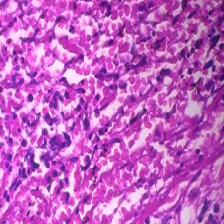

In [0]:
print( train_labels_enc[995:1005])
print(train_labels_enc[0])
array_to_img(train_imgs[0])

(224, 224, 3)


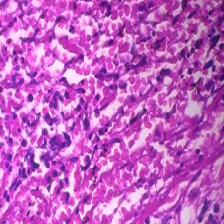

In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])


In [0]:
lr=1e-4
model = Sequential()

model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy'] )

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 86528)            

In [0]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,validation_data=(validation_imgs_scaled, validation_labels_enc),batch_size=batch_size,epochs=epochs,verbose=1)

Train on 1354 samples, validate on 659 samples
Epoch 1/30
1354/1354 [==============================] - 14s 10ms/step - loss: 0.5693 - accuracy: 0.7290 - val_loss: 0.2885 - val_accuracy: 0.9439
Epoch 2/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4806 - accuracy: 0.8065 - val_loss: 0.3351 - val_accuracy: 0.9302
Epoch 3/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4513 - accuracy: 0.8154 - val_loss: 0.3453 - val_accuracy: 0.9196
Epoch 4/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4335 - accuracy: 0.8183 - val_loss: 0.2588 - val_accuracy: 0.8907
Epoch 5/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4481 - accuracy: 0.8139 - val_loss: 0.2567 - val_accuracy: 0.9317
Epoch 6/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4124 - accuracy: 0.8390 - val_loss: 0.2345 - val_accuracy: 0.9302
Epoch 7/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.3976 - ac

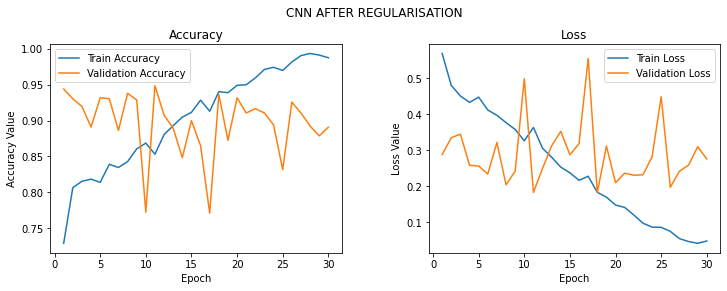

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN AFTER REGULARISATION', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy') ## changed acc to accuracy in history.history
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
train_datagen = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        rescale=1./255
    )
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=20)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (224, 224, 3)
batch_size=30


In [0]:
history = model.fit_generator(train_generator, steps_per_epoch=train_imgs.shape[0]/batch_size, epochs=100,validation_data=val_generator,verbose=1)

Epoch 1/100
46/45 [==============================] - 13s 281ms/step - loss: 0.6031 - accuracy: 0.8162 - val_loss: 0.1567 - val_accuracy: 0.9332
Epoch 2/100
46/45 [==============================] - 12s 259ms/step - loss: 0.4392 - accuracy: 0.8315 - val_loss: 0.4424 - val_accuracy: 0.7344
Epoch 3/100
46/45 [==============================] - 12s 259ms/step - loss: 0.4186 - accuracy: 0.8326 - val_loss: 0.4845 - val_accuracy: 0.8665
Epoch 4/100
46/45 [==============================] - 12s 256ms/step - loss: 0.3758 - accuracy: 0.8512 - val_loss: 0.2810 - val_accuracy: 0.8558
Epoch 5/100
46/45 [==============================] - 12s 259ms/step - loss: 0.3968 - accuracy: 0.8380 - val_loss: 0.3392 - val_accuracy: 0.8604
Epoch 6/100
46/45 [==============================] - 12s 259ms/step - loss: 0.3970 - accuracy: 0.8326 - val_loss: 0.3479 - val_accuracy: 0.8725
Epoch 7/100
46/45 [==============================] - 12s 260ms/step - loss: 0.3756 - accuracy: 0.8425 - val_loss: 0.2703 - val_accuracy:

In [0]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.2, min_lr=1e-7)

filepath="best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [0]:
BATCH_SIZE=30
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_imgs.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=val_generator,
    callbacks=[learn_control, checkpoint],verbose=1
)

Epoch 1/100
46/45 [==============================] - 12s 259ms/step - loss: 0.1744 - accuracy: 0.9344 - val_loss: 0.4280 - val_accuracy: 0.9014

Epoch 00001: val_accuracy improved from -inf to 0.90137, saving model to best.hdf5
Epoch 2/100
46/45 [==============================] - 11s 247ms/step - loss: 0.1840 - accuracy: 0.9315 - val_loss: 0.5011 - val_accuracy: 0.8680

Epoch 00002: val_accuracy did not improve from 0.90137
Epoch 3/100
46/45 [==============================] - 11s 247ms/step - loss: 0.1773 - accuracy: 0.9344 - val_loss: 0.1691 - val_accuracy: 0.9499

Epoch 00003: val_accuracy improved from 0.90137 to 0.94992, saving model to best.hdf5
Epoch 4/100
46/45 [==============================] - 11s 245ms/step - loss: 0.1984 - accuracy: 0.9196 - val_loss: 0.2753 - val_accuracy: 0.8923

Epoch 00004: val_accuracy did not improve from 0.94992
Epoch 5/100
46/45 [==============================] - 11s 243ms/step - loss: 0.2009 - accuracy: 0.9141 - val_loss: 0.0346 - val_accuracy: 0.92

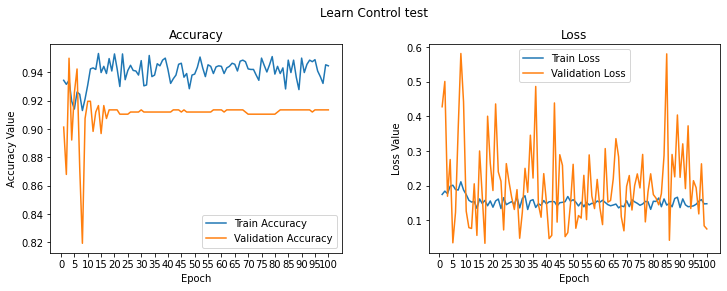

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Learn Control test', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy') ## changed acc to accuracy in history.history
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model = Sequential()
model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid'))    
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

74842112/74836368 [==============================] - 1s 0us/step


In [0]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.2, min_lr=1e-7)

filepath="best-densenet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_imgs.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=val_generator,
    callbacks=[learn_control, checkpoint],verbose=1
)

Epoch 1/40
46/45 [==============================] - 90s 2s/step - loss: 0.2595 - accuracy: 0.8928 - val_loss: 0.6659 - val_accuracy: 0.8376

Epoch 00001: val_accuracy improved from -inf to 0.83763, saving model to best-densenet.hdf5
Epoch 2/40
46/45 [==============================] - 90s 2s/step - loss: 0.2498 - accuracy: 0.8913 - val_loss: 0.8872 - val_accuracy: 0.8892

Epoch 00002: val_accuracy improved from 0.83763 to 0.88923, saving model to best-densenet.hdf5
Epoch 3/40
46/45 [==============================] - 90s 2s/step - loss: 0.1900 - accuracy: 0.9168 - val_loss: 0.1838 - val_accuracy: 0.8998

Epoch 00003: val_accuracy improved from 0.88923 to 0.89985, saving model to best-densenet.hdf5
Epoch 4/40
46/45 [==============================] - 90s 2s/step - loss: 0.2225 - accuracy: 0.9136 - val_loss: 0.2715 - val_accuracy: 0.9302

Epoch 00004: val_accuracy improved from 0.89985 to 0.93020, saving model to best-densenet.hdf5
Epoch 5/40
46/45 [==============================] - 90s 2s/

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_imgs.shape[0] / BATCH_SIZE,
    epochs=1,
    validation_data=val_generator,
    callbacks=[learn_control, checkpoint],verbose=1
)

Epoch 1/1
46/45 [==============================] - 90s 2s/step - loss: 0.2008 - accuracy: 0.9223 - val_loss: 0.1577 - val_accuracy: 0.9605

Epoch 00001: val_accuracy improved from 0.95448 to 0.96055, saving model to best-densenet.hdf5


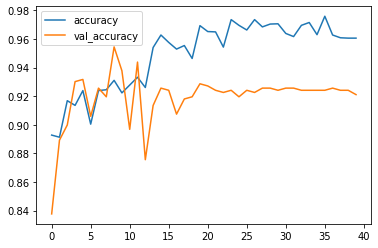

In [0]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [36]:
lr=1e-4
model = Sequential()
model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid'))    
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
model.load_weights("/content/drive/Shared drives/BTP_Arya/best-densenet.hdf5")
# Y_val_pred = model.predict(validation_imgs)
loss,acc = model.evaluate(validation_imgs,  validation_labels_enc, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


Restored model, accuracy: 45.68%


In [39]:
print(np.argmax(Y_val_pred, axis=1))
print(validation_labels_enc)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [41]:
accuracy_score((validation_labels_enc, np.argmax(Y_val_pred, axis=1)))

TypeError: ignored

In [0]:
# array_rain_fall = np.loadtxt(fname="rain-fall.csv", delimiter=",")
# np.savetxt(fname="train_imgs.csv", delimiter=",", X=train_imgs)
# np.savetxt(fname="train_imgs_enc.csv", delimiter=",", X=train_imgs_enc)

In [0]:
np.save("train_imgs.npy", train_imgs)

In [0]:
# /content/train_imgs.npy
# array_rain_fall_npy = np.load("saved-rain-fall-binary.npy")
np.save("train_labels_enc.npy", train_labels_enc)

In [0]:
np.save("validation_imgs.npy", validation_imgs)
np.save("validation_labels_enc.npy", validation_labels_enc)

In [0]:
array_rain_fall_npy = np.load("/content/drive/My Drive/train_labels_enc.npy")

[1 1 1 ... 1 0 1]
